In [15]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy 
from scipy.signal import find_peaks

from matplotlib import colors
from matplotlib import ticker

In [16]:
import matplotlib

nice_fonts = {
    "text.usetex": False,
    "font.size": 12,
    "axes.formatter.limits": (-2, 4),
    'xtick.direction': 'in',
    'ytick.direction': 'in',
}

matplotlib.rcParams.update(nice_fonts)

c1 = '#dc2f18'
c2 = '#2d82b7'
#c3 = '#aaae8e'
c3 = '#885a89'
c4 = '#07004d'
mcols = [c2, c3, c4, 'maroon']

In [17]:
def get_channel(runNo = 24100, ch = 10, dir = "../coldbox_data/"):
    filename = dir + f"adc_data_run_{runNo}_ch_{ch}_all.npy"
    dat = np.load(filename, allow_pickle=True)
    dat = dat.astype(np.int16) # else it's numpy.int64
    return dat

def subtract_pedestal(channel):
    # np.bincount(channel[0])[6980]
    #     returns of entries in the bin 6980
    # np.argmax(np.bincount(channel[i])): 
    #     returns the value of the most populated bin for event i
    peds = np.array([np.argmax(np.bincount(channel[i])) for i in range(len(channel))])
    peds = peds[:, np.newaxis] # reshaping, eg. array([1500, 1631, 1483]) -> array([[1500], [1631], [1483]])
    return channel - peds, peds
    

def quick_plot(data, title, axis):
    axis.plot(data.transpose())
    axis.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
    axis.set_ylabel(r"$\mathrm{\bf ADC\ counts}$")
    axis.set_title(title);

In [18]:
# neutrons
n = get_channel(runNo = 25036, ch = 40)
print(f'original shape: {n.shape}')
good_n = n[:, 3000:6000].copy()
print(f'selection: {good_n.shape}')
n, peds_n = subtract_pedestal(n)
good_n, peds_good_n = subtract_pedestal(good_n)
# n.shape
## 1000/65536 = 0.0152587890625
## one clock tick is about 15 ns

original shape: (16600, 65536)
selection: (16600, 3000)


In [5]:
# # cosmics
# ch_nb = 40
# cr = get_channel(runNo = 25066, ch = ch_nb)
# good_c = cr[:, 3000:6000].copy()
# print(f'original shape: {cr.shape}')
# print(f'selection: {good_c.shape}')
# cr, peds_cr = subtract_pedestal(cr)
# good_c, peds_good_c = subtract_pedestal(good_c)
# # cr.shape ## here tirgger every 4ms

### one sample at a time, flattened

In [6]:
data = good_n.flatten()
data.shape

(49800000,)

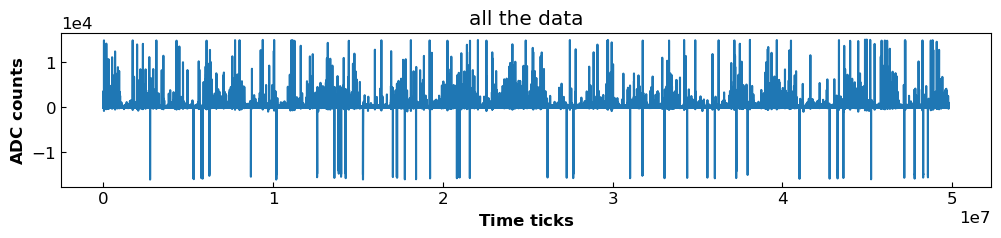

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(12, 2))
quick_plot(data, title='all the data', axis=axs)

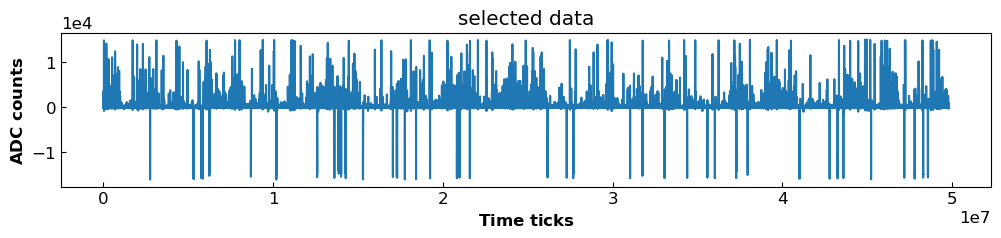

In [8]:
# data = data[0:200000]
fig, axs = plt.subplots(1, 1, figsize=(12, 2))
quick_plot(data, title='selected data', axis=axs)

# Waveforms

In [9]:
def find_waveforms(data, peaks, peak_heights, threshold=0.1, nTT_left=10, plot=False, verbose=False, win_min=0, win_max=0, sat_level=15000):
    """ 
      try to isolate the waveform using peak height
      threshold (between 0 and 1): value above (below) which the left (right) window is selected
      special cases:
       sometimes the rise time is very sharp (smaller than 1 time tick), in that case, we need to adapt the strategy
        nTT_left: the begining of the window on the left will be peak position - nTT_left
        -> not sure nTT is still useful
       
      win_max, win_min: max boundaries within which the waveform is, if 0 is provided, then there are no limits
      sat_level: number of ADC above which there is saturation (waveforms containing values above these are thrown away )
      
    """
    ### left, irght and peak correspond to the original position of the peak and window i
    dic = {'idx': [], 'left': [], 'right': [], 'peak': [], 'waveform': []}
    if plot:
        fig, axs = plt.subplots(1, 1, figsize=(12, 2))
        quick_plot(data, title='waveform finding', axis =axs)
        colors = ['orange', 'green', 'blue', 'red', 'black']

    for i in range(0, len(peaks)):
        # dic['idx'].append(i)
        # dic['peak'].append(peaks[i])
        if plot: axs.axvline(x = peaks[i], color = colors[i % len(colors)])
        peak10 = peak_heights[i]*threshold

        if win_min==0 and win_max==0:
            ## take abs diff -> 0 corresponds to exactly 10% (if threshold = 0.1), if not 0, then the minim(a) correspond to the closest values
            difference_array = np.absolute(data-peak10)
            ## get indices of the minima
            indices = np.array(np.where( difference_array == difference_array.min() ))[0] ## where() returns a tuple, need to cast into np.array
            ## select the left and right indices (w.r.t the peak position)
            left_indices  = indices[ np.where(indices < peaks[i]) ] 
            if np.any(left_indices)==False: 
                left_indices = [peaks[i]-nTT_left]
            right_indices = indices[ np.where(indices > peaks[i]) ] 
            if np.any(left_indices):  
                left  = left_indices[-1]
                # dic['left'].append(left)
            else: 
                left  = np.nan
                # dic['left'].append(np.nan)
            if np.any(right_indices): 
                right = right_indices[0]
                # dic['right'].append(right)
            else: 
                right = np.nan
                # dic['right'].append(np.nan)
        else:
            l = peaks[i]-win_min
            r = peaks[i]+win_max
            difference_array = np.absolute(data[l:r]-peak10)
            indices = np.array(np.where( difference_array == difference_array.min() ))[0]+l
            left_indices  = indices[ np.where(indices < peaks[i]) ] 
            right_indices = indices[ np.where(indices > peaks[i]) ] 
            
            if np.any(left_indices):
                left  = left_indices[-1]
            else:
                left = l
            
            if np.any(right_indices): 
                right = right_indices[0]
            else:
                right = r

        ## save waveform
        wf = data[left:right]
        if np.all(wf<sat_level):
            dic['idx'].append(i)
            dic['peak'].append(peaks[i])
            dic['left'].append(left)
            dic['right'].append(right)
            dic['waveform'].append(wf)
        # else: 
        #     dic['waveform'].append([]) ## would be better to really throw it away!
        

        if verbose:
            print()
            print(f'peaks[{i}] = {peaks[i]}, 10% of peak = {peak10}')
            if (win_min!=0 and win_max!=0): print(f'look around the peak ({l}, {r})')
            print('indices', indices)
            if np.any(left_indices):  print('left_indices',  left_indices)
            if np.any(right_indices): print('right_indices', right_indices)
            l_txt, r_txt = '', ''
            if np.any(left_indices):  l_txt = f'left = {left}' 
            if np.any(right_indices): r_txt = f'right = {right}'
            print(f'position of the min closest to peak, {l_txt}, {r_txt}')

        if plot:
            if (np.any(left_indices))  and ((i>0 and left > peaks[i-1])  or i==0): axs.axvline(x = left,    color = colors[i % len(colors)], linestyle='dashed') 
            if (np.any(right_indices)) and ((i>0 and right < peaks[i-1]) or i==0): axs.axvline(x = right,   color = colors[i % len(colors)],  linestyle='dashed')
        
    return dic

found 1828 peaks, after removing saturated peaks: 1717 (-> 111 with saturated peaks) 
1715 waveforms saved


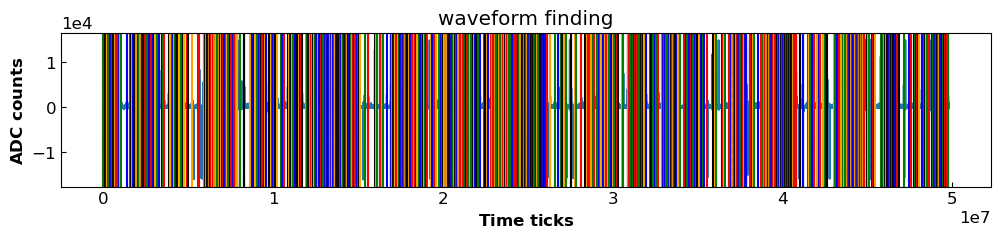

In [10]:
peaks, heights = find_peaks(data, height=1000, distance=150, prominence = 100, plateau_size = 0)
peaks_tot = len(peaks)
mask = heights['plateau_sizes'] < 2
peak_heights = heights['peak_heights'][mask]
peaks = peaks[np.where(mask)]
peaks_NoSat = len(peaks)
print(f'found {peaks_tot} peaks, after removing saturated peaks: {peaks_NoSat} (-> {peaks_tot - peaks_NoSat} with saturated peaks) ')

d = find_waveforms(data, peaks, peak_heights, threshold=0.1, nTT_left=10, plot=True, verbose=False, win_min=50, win_max=400, sat_level=14500)
print(f'{len(d["idx"])} waveforms saved')


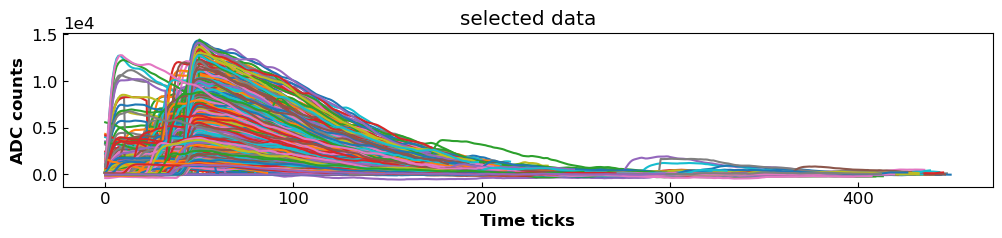

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(12, 2))
for w in d['waveform']:
    quick_plot(w, title='selected data', axis=axs)

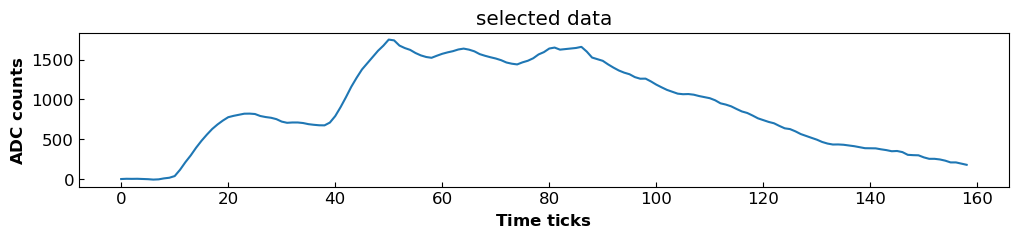

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(12, 2))
quick_plot(d['waveform'][1130], title='selected data', axis=axs)

In [13]:
# fig, axs = plt.subplots(1, 1, figsize=(12, 2))
# idx = d['peak'][1130]
# quick_plot(data[idx-1000: idx+1000], title='selected data', axis=axs)

In [14]:
data[idx-200: idx+1000].max()

NameError: name 'idx' is not defined